# Employee Performance Data Modelling and Prediction

## About
We try to predict employee performance scores based 300+ employee demographic characteristics. The dataset in question was acquired as part of a homework assignment and comprises of 20,000 employees and 379 employee characteristics, 1 target variable (employee performance score).

This note book details the loading, preprocessing, sampling, feature selection, modeling and write up of the pipeline.

Setting up the notebook settings

In [1]:
!--NotebookApp.iopub_data_rate_limit=1e11

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [0]:
import warnings
warnings.filterwarnings('ignore') 

In [0]:
# !pip install jupyter_contrib_nbextensions
# !pip install -U ipykernel
# !pip install jupyterthemes

# Project Flow Overview

1. Load Data
2. Cursory Description of Data
3. EDA
4. Feature Selection/ Extraction
5. Modelling
6. Prediction
7. Optimization
8. Modelling
9. End Point
10. Conclusion and Discussion

# 1. Load Data

In [4]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# get colmumn names for main dataset with key from other dataset
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.max_seq_items = 2000
import numpy as np

col_names = pd.read_csv("/content/drive/My Drive/sharpestminds_dataset/CodeBook-SELECT.csv")
col_names = col_names.loc[:, "VarName"].values

In [6]:
# load in the actual dataset
df = pd.read_csv("/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv", header="infer")
df.head()

,cntryid,cntryid_e,age_r,gender_r,computerexperience,nativespeaker,edlevel3,monthlyincpr,yearlyincpr,lng_home,cnt_h,cnt_brth,reg_tl2,lng_bq,lng_ci,yrsqual,yrsqual_t,yrsget,vet,ctryqual,birthrgn,nativelang,ctryrgn,imyrs,imyrs_c,imyrcat,ageg5lfs,ageg10lfs,ageg10lfs_t,edcat8,edcat7,edcat6,leaver1624,leavedu,fe12,aetpop,faet12,faet12jr,faet12njr,nfe12,...,v253,v132,v284,v267,v260,v26,v171,v14,v7,v240,v186,v162,v149,v228,v28,v237,v280,v175,v288,v15,v208,v43,v27,v114,v191,v170,v65,v57,v177,v69,v85,v50,v89,v127,v239,v224,v71,v105,row,uni
0,Canada,Canada (English),NaN,Female,Yes,Yes,Medium,50 to less than 75,50 to less than 75,999,NaN,NaN,99999,eng,eng,12.0,12.0,14.0,False,NaN,NaN,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 25-29,25-34,25-34,NaN,"Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)",NaN,NaN,Participated in FE,AET population,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons,Did not participate in NFE,...,Never,Every day,At least once a week,Never,At least once a week but not every day,At least once a week,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,Never,Never,Less than once a week but at least once a month,NaN,Yes,Every day,Every day,At least once a week but not every day,Never,Less than once a week but at least once a month,Never,Never,To a high extent,To a very high extent,To a high extent,To some extent,To a high extent,To a very high extent,Never,Disagree,Neither agree nor disagree,Agree,NaN,NaN,9999.0,9996.0,9999,9999.0,80219,cl3770
1,United Kingdom,England (UK),60.0,Male,Yes,Yes,High,75 to less than 90,75 to less than 90,eng,NaN,United Kingdom of Great Britain and Northern I...,UKJ,eng,eng,15.0,15.0,NaN,NaN,NaN,North America and Western Europe,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 60-65,55 plus,55 plus,Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),NaN,21.0,Did not participate in FE,AET population,Did not participate in formal AET,Did not participate in formal AET for JR reasons,Did not participate in FE for NJR reasons,Participated in NFE,...,At least once a week,Every day,At least once a week,At least once a week but not every day,Less than once a month,Rarely,At least once a week but not every day,Less than once a month,Every day,Every day,Less than once a week but at least once a month,Less than once a month,Less than once a week but at least once a month,NaN,Yes,Every day,Every day,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,Less than once a month,Less than once a month,To a high extent,To a high extent,To a high extent,To a high extent,To a high extent,To a very high extent,Never,Agree,Strongly agree,Agree,NaN,NaN,3118.0,9996.0,2520,9996.0,44314,cl3770
2,United Kingdom,England (UK),31.0,Male,Yes,Yes,High,75 to less than 90,75 to less than 90,eng,NaN,United Kingdom of Great Britain and Northern I...,UKI,eng,eng,16.0,16.0,NaN,NaN,NaN,North America and Western Europe,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 30-34,25-34,25-34,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,NaN,NaN,Participated in FE,AET population,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons,Participated in NFE,...,At least once a week,Less than once a week but at least once a month,Less than once a week but at least once a month,Less than once a month,Less than once a month,Rarely,Less than once a month,At least once a week but not every day,At least once a week but

### The dataset is a 93Mb csv file

In [7]:
!du -hs "/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv"

93M	/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv


In [8]:
# we have a lot of data here
print("{} features, {} observations".format(df.shape[1], df.shape[0]))

# we also have a lot of non-numeric data as well
print(df.info(memory_usage='deep'))

print(df.describe())

380 features, 20000 observations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 380 entries, cntryid to uni
dtypes: float64(80), int64(5), object(295)
memory usage: 357.9 MB
None
              age_r       yrsqual  ...          v105            row
count  12118.000000  17417.000000  ...  19979.000000   20000.000000
mean      39.339412     14.573549  ...   9833.138696   96825.751700
std       11.004673      2.703482  ...   1009.110938   57590.955791
min       16.000000      5.000000  ...     31.000000      98.000000
25%       31.000000     12.000000  ...   9996.000000   46369.000000
50%       38.000000     15.000000  ...   9996.000000   94729.000000
75%       48.000000     16.000000  ...   9996.000000  147668.500000
max       65.000000     22.000000  ...   9999.000000  197786.000000

[8 rows x 85 columns]


# 3. EDA - Missing Values

### We print out the the counts of observations with missing values in this dataset

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# There are a lot of missing values in this dataset
print(df.isnull().sum().sort_values(ascending=False)[df.isnull().sum() > 1000][:25])

v262    20000
v44     19997
v76     19993
v144    19992
v199    19991
v159    19985
v10     19981
v172    19977
v110    19956
v160    19955
v100    19955
v109    19954
v75     19938
v211    19938
v215    19936
v163    19935
v220    19927
v254    19923
v38     19910
v129    19910
v266    19907
v89     19864
v127    19828
v117    19793
v287    19792
dtype: int64


# Dropping Redundant Features

Based on the codebook and the naming conventions for this dataset, we will explore and determine which features could be dropped due to overlapping measures. Sometimes this is done as a result of differences in coding schemes or categorical aggregations of the result. We will do some investigation on these features, their level of correlation and multicollinearity with the target variable and decide which features we can drop during the preprocessing step.

In [10]:
# look at these features individually and drop stepwise after analysis

import re

pattern_earnhr = re.compile('\Aearnhr')
earnhr = [col for col in df.columns if re.match(pattern_earnhr, col) != None]
print(earnhr)

pattern_earnm = re.compile('\Aearnm')
earnm = [col for col in df.columns if re.match(pattern_earnm, col) != None]
print(earnm)

pattern_fn = re.compile('\Afn')
fn = [col for col in df.columns if re.match(pattern_fn, col) != None]
print(fn)

pattern_ed = re.compile('\Aed')
ed = [col for col in df.columns if re.match(pattern_ed, col) != None]
print(ed)

pattern_fae = re.compile('\Afae')
fae = [col for col in df.columns if re.match(pattern_fae, col) != None]
print(fae)

pattern_ict = re.compile('\Aict')
ict = [col for col in df.columns if re.match(pattern_ict, col) != None]
print(ict)

pattern_nfe12 = re.compile('\Anfe12')
nfe12 = [col for col in df.columns if re.match(pattern_nfe12, col) != None]
print(nfe12)

pattern_nfehrs = re.compile('\Anfehrs')
nfehrs = [col for col in df.columns if re.match(pattern_nfehrs, col) != None]
print(nfehrs)

pattern_writ = re.compile('\Awrit')
writ = [col for col in df.columns if re.match(pattern_writ, col) != None]
print(writ)

pattern_yrs = re.compile('\Ayrs')
yrs = [col for col in df.columns if re.match(pattern_yrs, col) != None]
print(yrs)

pattern_isco = re.compile('\Aisco')
isco = [col for col in df.columns if re.match(pattern_isco, col) != None]
print(isco)

pattern_isic = re.compile('\Aisic')
isic = [col for col in df.columns if re.match(pattern_isic, col) != None]
print(isic)

['earnhr', 'earnhrppp', 'earnhrbonus', 'earnhrbonusppp', 'earnhrdcl', 'earnhrbonusdcl']
['earnmth', 'earnmthppp', 'earnmthselfppp', 'earnmthbonus', 'earnmthall', 'earnmthallppp', 'earnmthbonusppp', 'earnmthalldcl']
['fnfaet12', 'fnfe12jr', 'fnfaet12jr', 'fnfaet12njr']
['edlevel3', 'edcat8', 'edcat7', 'edcat6', 'edwork']
['faet12', 'faet12jr', 'faet12njr']
['icthome', 'icthome_wle_ca', 'ictwork', 'ictwork_wle_ca']
['nfe12', 'nfe12jr', 'nfe12njr']
['nfehrsnjr', 'nfehrsjr', 'nfehrs']
['writhome', 'writhome_wle_ca', 'writwork', 'writwork_wle_ca']
['yrsqual', 'yrsqual_t', 'yrsget']
['iscoskil4', 'isco1c', 'isco2c', 'isco1l', 'isco2l']
['isic1l', 'isic2l', 'isic1c', 'isic2c']


### Earnhr Features

Earnings on an hourly basis

In [11]:
# earnhr features
earnhr_df = df[earnhr + ['earnflag']]
print("Percent of missing data by Hourly Earnings")
print((earnhr_df.isnull().sum()/earnhr_df.shape[0] * 100).sort_values(ascending=False))


Percent of missing data by Hourly Earnings
earnhrbonusppp    58.395
earnhrbonus       58.395
earnhrppp         58.160
earnhr            58.160
earnhrbonusdcl    27.050
earnhrdcl         26.815
earnflag          21.070
dtype: float64


In [12]:
earnhr_df.head()

,earnhr,earnhrppp,earnhrbonus,earnhrbonusppp,earnhrdcl,earnhrbonusdcl,earnflag
0,NaN,NaN,NaN,NaN,7th decile,7th decile,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,Reported directly
2,NaN,NaN,NaN,NaN,NaN,NaN,Reported directly
3,NaN,NaN,NaN,NaN,NaN,NaN,Reported directly
4,NaN,NaN,NaN,NaN,Lowest decile,Lowest decile,Reported directly


Drop: earnhrbonusppp, earnhrbonus, earnhrppp, earnhr

Keep: earnflag, earnhrdcl, earnhrbonusdcl

In [0]:
features_earnhr_drop = ['earnhrbonusppp', 'earnhrbonus', 'earnhrppp', 'earnhr']
df.drop(features_earnhr_drop, inplace=True, axis=1)

### Earnm Features

Earnings on a monthly basis

In [14]:
# earnm features
earnm_df = df[earnm + ['earnflag']]
print("Percent of missing data by Monthly Earnings")
print((earnm_df.isnull().sum()/earnm_df.shape[0] * 100).sort_values(ascending=False))


Percent of missing data by Monthly Earnings
earnmthselfppp     93.370
earnmthbonusppp    58.355
earnmthbonus       58.355
earnmthppp         58.055
earnmth            58.055
earnmthallppp      51.725
earnmthall         51.725
earnflag           21.070
earnmthalldcl      15.670
dtype: float64


In [15]:
earnm_df.head(5)

,earnmth,earnmthppp,earnmthselfppp,earnmthbonus,earnmthall,earnmthallppp,earnmthbonusppp,earnmthalldcl,earnflag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6th decile,NaN
1,NaN,NaN,4915.959463,NaN,3333.333333,4915.959463,NaN,2nd decile,Reported directly
2,NaN,NaN,4485.813010,NaN,3041.666667,4485.813010,NaN,2nd decile,Reported directly
3,NaN,NaN,3153.961720,NaN,28000.000000,3153.961720,NaN,7th decile,Reported directly
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9th decile,Reported directly


Drop: earnmthbonusppp, earnmthselfppp, earnmthbonus, earnmthppp, earnmth, earnmthallppp, earnmthall


Keep: earnflag, earnmthalldcl

In [0]:
features_earnm_drop = ['earnmthbonusppp', 'earnmthselfppp', 'earnmthbonus', 'earnmthppp', 'earnmth', 'earnmthallppp', 'earnmthall']
df.drop(features_earnm_drop, inplace=True, axis=1)

In [17]:
df.earnmthalldcl.unique()

array(['6th decile', '2nd decile', '7th decile', '9th decile',
       '3rd decile', 'Highest decile', '5th decile', nan, 'Lowest decile',
       '8th decile', '4th decile'], dtype=object)

In [0]:
# ordinalize the string values of this earnmthalldcl

df['earnmthalldcl'] = pd.Categorical(df['earnmthalldcl'], 
                                  categories=['Lowest decile', 
                                                '2nd decile', 
                                                '3rd decile', 
                                                '4th decile', 
                                                '5th decile', 
                                                '6th decile', 
                                                '7th decile',
                                                '8th decile', 
                                                '9th decile', 
                                                'Highest decile'], 
                                  ordered=True
                                 )

In [19]:
df['earnmthalldcl'].head()

0    6th decile
1    2nd decile
2    2nd decile
3    7th decile
4    9th decile
Name: earnmthalldcl, dtype: category
Categories (10, object): [Lowest decile < 2nd decile < 3rd decile < 4th decile ... 7th decile <
                          8th decile < 9th decile < Highest decile]

### fn Features

Formal or information education within the last 12 months

In [20]:
# fn features
fn_df = df[fn + ['fe12']]
print("Percent of missing data by Formal Education")
print((fn_df.isnull().sum()/fn_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by Formal Education
fnfaet12njr    5.200
fnfaet12jr     5.200
fnfaet12       5.170
fnfe12jr       0.435
fe12           0.000
dtype: float64


In [21]:
fn_df.head()

,fnfaet12,fnfe12jr,fnfaet12jr,fnfaet12njr,fe12
0,Participated in formal and/or non-formal AET,Participated in FE or NFE for JR reasons,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,Participated in FE
1,Participated in formal and/or non-formal AET,Participated in FE or NFE for JR reasons,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,Did not participate in FE
2,Participated in formal and/or non-formal AET,Participated in FE or NFE for JR reasons,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,Participated in FE
3,Participated in formal and/or non-formal AET,Participated in FE or NFE for JR reasons,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,Did not participate in FE
4,NaN,Participated in FE or NFE for JR reasons,NaN,NaN,Participated in FE


Drop: fnfaet12njr, fnfaet12jr, fnfaet12, fnfe12jr

Keep: fe12

In [0]:
features_fn_drop = ['fnfaet12njr', 'fnfaet12jr', 'fnfaet12', 'fnfe12jr']
df.drop(features_fn_drop, inplace=True, axis=1)

### ed Features

Highest level of formal education.

In [23]:
# ed features
ed_df = df[ed]
print("Percent of missing data by Education")
print((ed_df.isnull().sum()/ed_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by Education
edcat8      16.935
edlevel3     0.930
edcat6       0.060
edcat7       0.060
edwork       0.005
dtype: float64


In [24]:
ed_df.head()

,edlevel3,edcat8,edcat7,edcat6,edwork
0,Medium,NaN,"Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)",In education and work
1,High,Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),In work only
2,High,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,In education and work
3,High,Tertiary – master degree (ISCED 5A),Tertiary – master/research degree (ISCED 5A/6),Tertiary – master/research degree (ISCED 5A/6),In work only
4,Medium,"Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)",In education and work


Drop: edcat8, edwork, edcat6, edlevel3

Keep: edcat7

In [0]:
features_ed_drop = ['edcat8', 'edwork', 'edcat6', 'edlevel3']
df.drop(features_ed_drop, inplace=True, axis=1)

In [0]:
# Ordinalize the edcat7 categorical feature

df['edcat7'] = pd.Categorical(df['edcat7'],
                          categories=['Primary or less (ISCED 1 or less)',
                                     'Lower secondary (ISCED 2, ISCED 3C short)',
                                     'Upper secondary (ISCED 3A-B, C long)',
                                     'Post-secondary, non-tertiary (ISCED 4A-B-C)',
                                     'Tertiary – bachelor degree (ISCED 5A)',
                                     'Tertiary – master/research degree (ISCED 5A/6)\xa0',
                                     'Tertiary - bachelor/master/research degree (ISCED 5A/6)',
                                     'Tertiary – professional degree (ISCED 5B)'],
                          ordered=True)

In [27]:
df['edcat7'].head()

0                 Upper secondary (ISCED 3A-B, C long)
1            Tertiary – professional degree (ISCED 5B)
2    Tertiary - bachelor/master/research degree (IS...
3      Tertiary – master/research degree (ISCED 5A/6) 
4                 Upper secondary (ISCED 3A-B, C long)
Name: edcat7, dtype: category
Categories (8, object): [Primary or less (ISCED 1 or less) < Lower secondary (ISCED 2, ISCED 3C short) <
                         Upper secondary (ISCED 3A-B, C long) < Post-secondary, non-tertiary (ISCED 4A-B-C) <
                         Tertiary – bachelor degree (ISCED 5A) < Tertiary – master/research degree (ISCED 5A/6) <
                         Tertiary - bachelor/master/research degree (IS... < Tertiary – professional degree (ISCED 5B)]

### fae Features

Formal AET

In [28]:
# FAE features
fae_df = df[fae]
print("Percent of missing data by Formal AET")
print((fae_df.isnull().sum()/fae_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by Formal AET
faet12njr    5.205
faet12jr     5.205
faet12       5.170
dtype: float64


In [29]:
fae_df.head()

,faet12,faet12jr,faet12njr
0,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons
1,Did not participate in formal AET,Did not participate in formal AET for JR reasons,Did not participate in FE for NJR reasons
2,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons
3,Did not participate in formal AET,Did not participate in formal AET for JR reasons,Did not participate in FE for NJR reasons
4,NaN,NaN,NaN


Drop: faet12njr, faet12hr

Keep: faet12

In [0]:
features_fae_drop = ['faet12njr', 'faet12jr']
df.drop(features_fae_drop, inplace=True, axis=1)

### ict Features

Index of Information, Communication and Technology capabilities

In [31]:
# earnm features
ict_df = df[ict]
print("Percent of missing data by ICT")
print((ict_df.isnull().sum()/ict_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by ICT
ictwork           7.495
icthome           7.180
ictwork_wle_ca    6.775
icthome_wle_ca    6.770
dtype: float64


In [32]:
ict_df.head()

,icthome,icthome_wle_ca,ictwork,ictwork_wle_ca
0,2.261395,More than 40% to 60%,2.624086,More than 60% to 80%
1,3.538845,More than 80%,2.237029,More than 60% to 80%
2,2.624791,More than 60% to 80%,2.067996,More than 40% to 60%
3,3.479338,More than 80%,4.466779,More than 80%
4,2.645463,More than 60% to 80%,0.665753,Lowest to 20%


Drop: 'icthome_wle_ca', 'ictwork_wle_ca' 

Keep: ictwork, icthome

In [0]:
features_ict_drop = [ 'icthome_wle_ca', 'ictwork_wle_ca' ]
df.drop(features_ict_drop, inplace=True, axis=1)

### nfe12 Features

Only informal education within the last 12 months

In [34]:
# nfe12 features
earnm_nfe12 = df[nfe12]
print("Percent of missing data by Informal Education with the last 12 months")
print((earnm_nfe12.isnull().sum()/earnm_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by Informal Education with the last 12 months
nfe12njr    0.42
nfe12jr     0.42
nfe12       0.42
dtype: float64


In [35]:
earnm_nfe12.head()

,nfe12,nfe12jr,nfe12njr
0,Did not participate in NFE,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons
1,Participated in NFE,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons
2,Participated in NFE,Did not participate in NFE for JR reasons,Participated in NFE for NJR reasons
3,Participated in NFE,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons
4,Did not participate in NFE,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons


Drop: nfe12jr, nfe12njr

Keep: nfe12

In [0]:
features_nfe12_drop = ['nfe12jr', 'nfe12njr']
df.drop(features_nfe12_drop, inplace=True, axis=1)

### nfehrs Features

In [37]:
# nfehrs features
nfehrs_df = df[nfehrs]
print("Percent of missing data by Informal Education Hours")
print((nfehrs_df.isnull().sum()/nfehrs_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by Informal Education Hours
nfehrsjr     51.365
nfehrsnjr    51.365
nfehrs       39.775
dtype: float64


In [38]:
nfehrs_df.head()

,nfehrsnjr,nfehrsjr,nfehrs
0,NaN,NaN,NaN
1,0.0,40.0,40.0
2,NaN,NaN,40.0
3,NaN,NaN,320.0
4,NaN,NaN,NaN


Drop: nfehrsjr, nfehrsnjr

Keep: nfehrs

In [0]:
features_nfehrs = ['nfehrsjr', 'nfehrsnjr']
df.drop(features_nfehrs, inplace=True, axis=1)

### writ Features

Writing capabilities

In [40]:
# writ features
writ_df = df[writ]
print("Percent of missing data by Writing Capabilities")
print((writ_df.isnull().sum()/writ_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by Writing Capabilities
writhome           4.705
writwork           1.900
writwork_wle_ca    0.000
writhome_wle_ca    0.000
dtype: float64


In [41]:
writ_df.head()

,writhome,writhome_wle_ca,writwork,writwork_wle_ca
0,2.574343,More than 60% to 80%,3.690521,More than 80%
1,3.116459,More than 80%,3.101801,More than 80%
2,2.979574,More than 80%,2.818857,More than 80%
3,3.036055,More than 80%,3.690521,More than 80%
4,2.675496,More than 60% to 80%,0.056130,Lowest to 20%


Drop: writhome_wle_ca, writwork_wle_ca

Keep: writhome, writwork

In [0]:
features_writ_drop = [ 'writhome_wle_ca', 'writwork_wle_ca' ]
df.drop(features_writ_drop, inplace=True, axis=1)

## yrs features

Imputed years of formal education needed to get the job (self-reported - estimated), Highest level of education obtained imputed into years of education (estimated), Derived variable on total years of schooling during lifetime - top coded at 24 (Trend)

In [43]:
# writ features
yrs_df = df[yrs]
print("Percent of missing data by Writing Capabilities")
print((yrs_df.isnull().sum()/yrs_df.shape[0] * 100).sort_values(ascending=False))

Percent of missing data by Writing Capabilities
yrsget       22.005
yrsqual_t    13.845
yrsqual      12.915
dtype: float64


In [44]:
yrs_df.head()

,yrsqual,yrsqual_t,yrsget
0,12.0,12.0,14.0
1,15.0,15.0,NaN
2,16.0,16.0,NaN
3,18.0,18.0,NaN
4,12.0,12.0,12.0


Drop: yrsget, yrsqual

Keep: yrsqual_t

In [0]:
features_yrs_drop = ['yrsget', 'yrsqual']
df.drop(features_yrs_drop, inplace=True, axis=1)


## yearlyincpr

Yearly income percentile rank category (estimated)

In [46]:
print("Percent of missing data by Yearly Income PCT rank category")
print((df.yearlyincpr.isnull().sum()/df.yearlyincpr.shape[0]) * 100)

Percent of missing data by Yearly Income PCT rank category
16.195


In [47]:
df.yearlyincpr.value_counts()

50 to less than 75    4221
75 to less than 90    3967
90 or more            3903
25 to less than 50    2747
10 to less than 25    1111
Less than 10           812
Name: yearlyincpr, dtype: int64

In [48]:
df.loc[:10, ['yearlyincpr', 'earnmthalldcl']]

,yearlyincpr,earnmthalldcl
0,50 to less than 75,6th decile
1,75 to less than 90,2nd decile
2,75 to less than 90,2nd decile
3,25 to less than 50,7th decile
4,10 to less than 25,9th decile
5,25 to less than 50,6th decile
6,50 to less than 75,3rd decile
7,90 or more,Highest decile
8,25 to less than 50,5th decile
9,75 to less than 90,2nd decile


Keep: yearlyincpr

In [0]:
# ordinalize yearlyincpr

df.yearlyincpr = pd.Categorical(df['yearlyincpr'], 
                                categories=["Less than 10", "10 to less than 25", 
                                            "25 to less than 50", '50 to less than 75', 
                                            '75 to less than 90', '90 or more'], 
                                ordered=False)

In [0]:
# ordinalize iscoskil4

df.iscoskil4 = pd.Categorical(df['iscoskil4'], 
                categories=['Elementary occupations', 
                            'Skilled occupations',
                            'Semi-skilled blue-collar occupations', 
                            'Semi-skilled white-collar occupations'], 
                ordered=True)


## ISCO features

Occupational classification of respondent's job 

In [51]:
# isic features
isco_df = df[isco]
print("Percent of missing data by Industry classification")
print(((isco_df.isnull().sum()/isco_df.shape[0]) * 100).sort_values(ascending=False))

Percent of missing data by Industry classification
iscoskil4    1.2
isco2l       0.0
isco1l       0.0
isco2c       0.0
isco1c       0.0
dtype: float64


In [52]:
isco_df.head()

,iscoskil4,isco1c,isco2c,isco1l,isco2l
0,Skilled occupations,3,9999,9996,9996
1,Skilled occupations,3,31,9996,9996
2,Skilled occupations,2,24,9996,9996
3,Skilled occupations,3,33,9996,9996
4,Semi-skilled blue-collar occupations,8,83,9996,9996


Drop: isco2l, isco1l, isco1c

Keep: isco2c

In [0]:
features_isco_drop = ['isco2l', 'isco1l', 'isco1c']
df.drop(features_isco_drop, inplace=True, axis=1)


## isic features

Industrial classification of respondent's job 

In [54]:
# isic features
isic_df = df[isic]
print("Percent of missing data by Industry classification")
print(((isic_df.isnull().sum()/isic_df.shape[0]) * 100).sort_values(ascending=False))

Percent of missing data by Industry classification
isic2l    6.08
isic2c    0.43
isic1c    0.00
isic1l    0.00
dtype: float64


In [55]:
isic_df.head()

,isic1l,isic2l,isic1c,isic2c
0,9999,NaN,M,9999
1,9996,9996,C,25
2,9996,9996,D,35
3,9996,9996,N,82
4,9996,9996,G,45


Drop: isic2l, isic1l, isic2c

Keep: isic1c

In [0]:
features_isic_drop = ['isic2l', 'isic1l', 'isic2c']
df.drop(features_isic_drop, inplace=True, axis=1)

# Preprocessing (Dropping and Replacing) for Missing/Unavailable Value Encodings

With this particular dataset, some missing or unavailable column values are encoded as a numeric value. Some particular values that were used to encode these values are: 999, 9996, 9997, 9998, 9999, 99999. Let's have a look at them first. Our next step would be to map these values to np.nan for imputation afterwards. We make a list of these notable features.

Also note that for some features, the integer values or float are actually strings, thus making the feature column itself an object column. What we would want here is to cast these specifically as integers, after having dealt with the letter encodings. Using Int64
* ~~v71~~ -> cast letters to np.nan, cast values to np.nan, cast all to Int64
* ~~v105~~ -> drop

Letter columns that use numeric encodings to indicate missing:
* ~~isic1c~~ -> replace num string as np.nan

In [0]:
possible_missing_data_codes = ['999', 9995, '9995', 9996, '9996' ,9997, 9998,'9998', 9999, '9999', '99999']

Drop v105 because it is the same as isic features and we already drop those. 

We then impute the missing/unavailable encoded values in isic1c with np.nan

In [0]:
# v105 is to v71 what isic1l is to isic1c; one refers to industry of last job and one refers to industry of current job
df.drop(['v71', 'v105'], inplace=True, axis=1)

In [59]:
df.isic1c.unique()

array(['M', 'C', 'D', 'N', 'G', 'P', 'I', 'O', 'K', 'F', 'A', 'L', 'R',
       '9996', 'Q', 'H', 'J', '9999', 'B', '9995', 'T', '9998', 'S', 'E',
       '9997'], dtype=object)

In [0]:
missing_values_to_replace = ['9995', '9996', '9997', '9998', '9999']

df['isic1c'].replace(to_replace=missing_values_to_replace, value=np.nan, inplace=True)

# Drop Missing Data by Axes

## Missing Data Proportion by Columns
We will want to drop a number of the columns have have a significant amount of its data missing. Some features have disproportionately more data missing than others and there will be no way to impute those features. In which case dropping those features might be the best course of action to clean up the dataset. Feature column values that have a proportion of their data missing equal to or greater than an arbitrary threshold will have their columns dropped. Afterwards, a row-wise operation of this procedure will be further applied to include cleaner samples in the dataset. 
________________

We will examine to see which features reach this threshold requirement to be dropped before we do any such dropping. 
____________ 

Afterwards, we will want to smarly impute the remaining missing data points as much as we can.

In [61]:
# features by % of missing data
dropthreshold = 50

pct_missing_list = list([col for col in df.columns if df[col].isnull().sum()/df.shape[0] * 100 >= dropthreshold])
pm_list = []


for col in df.columns:
    if df[col].isnull().sum()/df.shape[0] * 100 >= dropthreshold:
        pm_list.append(df[col].isnull().sum()/df.shape[0] * 100)
        
dropped_columns_dataframe = pd.DataFrame(pm_list, columns=['% Missing Data'], index=pct_missing_list).sort_values(by='% Missing Data', ascending=False)

# get the data points in the dataframe that have >= 50% of their data missing
df_col_drop_gtoe_50 = df[pct_missing_list]
kept_feat_cols = list(set(df.columns) - set(pct_missing_list))
reduced_df = df[kept_feat_cols]

print("The features with {}% or more of it's data missing will be dropped from the dataset.".format(dropthreshold))
print("{} Columns will be dropped, which constitutes a {}% drop in the number of features from the original dataset".format(
    len(df.columns) - len(kept_feat_cols), 
    ((len(df.columns) - len(kept_feat_cols)) / len(df.columns)) * 100
)
     )

# save the results to csv to look at later
dropped_columns_dataframe.to_csv('./features_greater_50_percent_missing_data_by_cols.csv')

# write out the dataframe after having dropped the columns
reduced_df.to_csv('./reduced_df_gtoe_{}_missing_df.csv'.format(dropthreshold))

The features with 50% or more of it's data missing will be dropped from the dataset.
125 Columns will be dropped, which constitutes a 36.65689149560117% drop in the number of features from the original dataset


In [0]:
def report_missing(preproc_data, postproc_data, axis=1, dropthreshold=None):
    """ dataset in dataframe format passed in is before and after dropping feature columns or rows. """
    print("The features with {}% or more of it's data missing will be dropped from the dataset.".format(dropthreshold))
    
    if axis == 1:
        print("{} Columns will be dropped, which constitutes a {}% drop in the number of features from the original dataset".format(
        len(preproc_data.columns) - len(postproc_data.columns), 
        ((len(preproc_data.columns) - len(postproc_data.columns)) / len(preproc_data.columns)) * 100
    )
         )
    
    else:
        print("{} Data Points will be dropped, which constitutes a {}% drop in the number of data points from the original dataset".format(
        preproc_data.shape[0] - postproc_data.shape[0], 
        ((preproc_data.shape[0] - postproc_data.shape[0]) / preproc_data.shape[0]) * 100
    )
         )
    


## Missing Data Proportion By Row 
An alternative strategy would be just to drop all of the rows with missing values. This step requires a little more wor as we will have more than 0 data points that have missing values and require imputation of missing values.


Lets first drop any data ROWS with 20% or more missing values and see what we end up with.

________________


Just a refresher on how to how to conditionally select rows from a data frame:

To select rows whose column value equals a scalar, some_value, use ==:
df.loc[df['column_name'] == some_value]


To select rows whose column value is in an iterable, some_values, use isin:
df.loc[df['column_name'].isin(some_values)]

Combine multiple conditions with &:
df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]

Conditionally set values
df[label] = df.variable.where('label' == 'another_label')





In [63]:
# Data points with percentage of data missing and greater will be dropped from the dataset
dropthreshold = 20

# get the data points in the dataframe that have >= 30% of their data missing
to_drop_df = reduced_df.loc[(reduced_df.isnull().sum(axis=1)/reduced_df.shape[1]*100) >= dropthreshold]
row_reduced_df = reduced_df.loc[(
    reduced_df.isnull().sum(axis=1) / reduced_df.shape[1]*100 < dropthreshold
)]

report_missing(reduced_df, row_reduced_df, axis=0, dropthreshold=dropthreshold)

# give the new dataframe a better name
final_kept_df = row_reduced_df

# save the dataframe to disk after the processing
final_kept_df.to_csv('./final_kept_df.csv')

The features with 20% or more of it's data missing will be dropped from the dataset.
1304 Data Points will be dropped, which constitutes a 6.52% drop in the number of data points from the original dataset


## Missing Data by Data Type
We can see that there are a considerable amount of missing values for this dataset. We will have to dig in to understand which features would have missing values, and can we come up with a strategy to handle it.

In [64]:
# separate out the numeric and categorical variables to see how much of each are missing
def df_by_type_splitter(dataframe):
    """ a larger dataframe into immediately identifiable numeric and other type dataframes"""
    num_df = dataframe._get_numeric_data().copy()
    cat_df = dataframe.select_dtypes(exclude = [int, float]).copy()

    return num_df, cat_df


numeric_df, categorical_df = df_by_type_splitter(row_reduced_df)


print("Number of Numeric Features: {}".format(numeric_df.shape[1]))
print("Number of Categorical Features: {}".format(categorical_df.shape[1]))

Number of Numeric Features: 31
Number of Categorical Features: 185


## Numeric Feature Missing Values

It still appears that after dropping the data points and features with a majority of their data points missing, that about a third of the numeric features containg NaN/missing values in more than 20% of their data points.

Proportionally, numeric features contribute 14.35% of the total features in the dataset
leavedu        44.228712
v202           39.120668
age_r          38.928113
v231           38.350449
nfehrs         38.088361
v272           37.836970
v52            37.601626
v33            37.569534
v63            36.360719
yrsqual_t      13.441378
learnatwork     7.980317
v135            7.541720
dtype: float64
The number of numeric features with more than 20% of its values missing is: 9, which is 29.03225806451613% of all numeric features


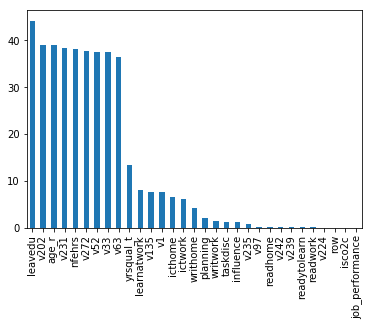

In [65]:
# take a look at the missing values from the numeric features dataframe
print("Proportionally, numeric features contribute {0:.2f}% of the total features in the dataset".format(numeric_df.shape[1]/final_kept_df.shape[1]*100))
a = pd.Series(numeric_df.isnull().sum().sort_values(ascending=False)/(numeric_df.shape[0]) * 100)
print(a[:12])
a.plot(kind='bar')

# 9 numeric features of 37 with more than 20% of it's data missing
print("The number of numeric features with more than 20% of its values missing is: {}, which is {}% of all numeric features".format(9, (9/numeric_df.shape[1]*100)))

We are going to explore correlation/collinearity between the numeric features and drop redundant features.

In [66]:
# categorical feature with numeric encoding

cat_feat_with_num_encoding = ['v224','v239', 'isco2c']
for i in cat_feat_with_num_encoding:
    print("This categorical feature with numeric encodings has {} unique values: {}".format(i, len(numeric_df[i].unique())))

This categorical feature with numeric encodings has v224 unique values: 27
This categorical feature with numeric encodings has v239 unique values: 413
This categorical feature with numeric encodings has isco2c unique values: 50


Although semantically inappropriate, let's, as an exercise, treat these high-category numerically encoded features as numeric features. Depening on the results of our exploration, we may go back to treating these features as categorical variables in the final model.

## Pre-Imputer Imputation for numeric features
Some further processing can be done before the imputation step such as (dropping,casting, merging, etc). The next few segments of code will go through the next preprocessing steps as outlined above.

In [0]:
# we drop 'age_r' as there is another categorical feature containing the same demographic information with more completeness, with the tradeoff of numeric granularity

numeric_df.drop(columns='age_r', inplace=True, axis=1)

In [0]:
# we drop 'row' because this is a pretty useless category

numeric_df.drop(columns='row', inplace=True, axis=1)

Because v239 has many numeric encodings as a categorical feature, we can initially treat it as a numeric feature and then see whether there is a relationship between it and the response variable: 'job_performance'. We keep the variable if it is a strong predictor of employee job performance; otherwise, we drop the largely-categorized variable.

As we can gleen from the heatmap below in Seaborn, there is no correlation between the feature v239 (current occupation) and job performance of an employee, if current occuptational coding were treated as a numeric variable.

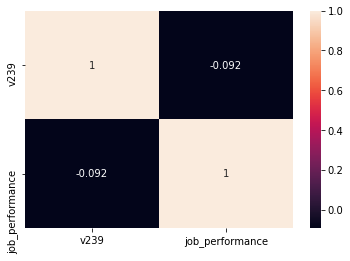

In [69]:
import seaborn as sns

o = pd.DataFrame(numeric_df['v239'].fillna(value=numeric_df['v239'].median()))
o['job_performance'] = numeric_df['job_performance']
corr = o.corr()
sns.heatmap(corr, annot=True)

What happens when we look at v239 as a categorical feature? Well, we don't really get to see much of anything at all from onehot encoding this highly categorized feature.

   job_performance  7.0  8.0  12.0  ...  9996.0  9997.0  9998.0  9999.0
4      2079.471114    0    0     0  ...       0       0       0       1
5      3197.167530    0    0     0  ...       0       0       0       0
6      2627.234538    0    0     0  ...       0       0       0       0
7      3147.474706    0    0     0  ...       0       0       0       1
8      2618.112809    0    0     0  ...       0       0       0       1

[5 rows x 412 columns]


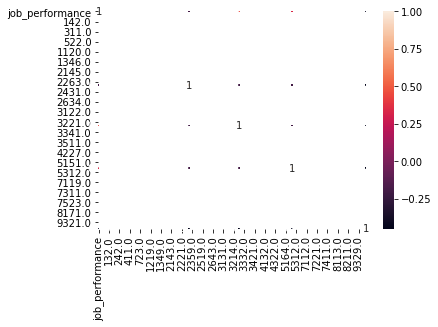

In [70]:
get_dummy_features = pd.get_dummies(o['v239'], drop_first=True)
temp_df_dummies = pd.concat([o[['job_performance']], get_dummy_features], axis=1).iloc[4:10]
print(temp_df_dummies.head())

corr = temp_df_dummies.corr()
sns.heatmap(corr, annot=True)

So it looks like for now, it is safe to drop this feature

In [0]:
# Dropping feature 'v239'

numeric_df.drop('v239', axis=1, inplace=True)

We will then choose to impute the rest of the missing numeric features, during our imputation step.

## Examination of the categorical features

Proportionally, categorical features contribute 85.65% of the total features in the dataset
ctryqual          47.432606
v291              45.811938
v137              45.250321
cnt_brth          43.993368
v3                39.190201
birthrgn          37.366282
v269              35.761660
v91               35.745614
v47               33.290543
v236              33.178220
v289              27.251819
v96               24.919769
earnhrbonusdcl    22.368421
earnhrdcl         22.117030
v255              21.266581
v212              21.074027
reg_tl2           20.180787
v62               17.233633
earnflag          16.714805
v8                16.442020
dtype: float64
The number of categorical features with more than 20% of its values missing is: 17, which is 9.18918918918919% of all categorical features


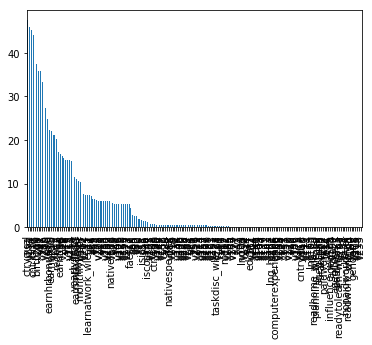

In [72]:
# take a look at the missing values for categorical features dataframe
print("Proportionally, categorical features contribute {0:.2f}% of the total features in the dataset".format(categorical_df.shape[1]/final_kept_df.shape[1]*100))
print((categorical_df.isnull().sum().sort_values(ascending=False)/(categorical_df.shape[0]) * 100 )[:20])
b = pd.Series(categorical_df.isnull().sum().sort_values(ascending=False)/(categorical_df.shape[0]) * 100 )
b.plot(kind='bar')

# 17 features with more than 20% of its values missing of 205 features
print("The number of categorical features with more than 20% of its values missing is: {}, which is {}% of all categorical features".format(17, 17/categorical_df.shape[1]*100))

In [73]:
temp = pd.DataFrame(categorical_df.columns, columns=['feature_name'])
temp['num_unique_values'] = [len(categorical_df[col].unique()) for col in categorical_df.columns]
print("There are {} features that have <=10 unique values in feature column, which could benefit greatly from categorization.".format(temp[temp['num_unique_values'] <= 10].sort_values('num_unique_values', ascending=False).shape[0]))
print("This is {0:.2f}% of the categorical features that could benefit from categorization optimization".format(temp[temp['num_unique_values'] <= 10].shape[0]/categorical_df.shape[1] * 100))

There are 171 features that have <=10 unique values in feature column, which could benefit greatly from categorization.
This is 92.43% of the categorical features that could benefit from categorization optimization


In [74]:
# we can see that the categorical features, because of many data points and features there are, contribute heavily to the memory usage

categorical_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18696 entries, 0 to 19999
Columns: 185 entries, v85 to v74
dtypes: category(4), object(181)
memory usage: 231.8 MB


In [75]:
# have a look at the memory usage of the top 10 object columns before categorization

categorical_df[[col for col in categorical_df.columns if len(categorical_df[col].unique()) <= 10]].memory_usage(deep=True)[:10].sort_values(ascending=False)

v122                  1774191
v34                   1416454
planning_wle_ca       1387720
influence_wle_ca      1383578
v200                  1348598
v85                   1252554
ageg10lfs             1171450
computerexperience    1121515
v227                  1107972
Index                  149568
dtype: int64

We can cast some of the object features to category to better optimize for memory usage and computation, however  we can only do this after the nan values and other values are imputed.

## Unique categorical groupings in the categorical features 

Just to get a little perspective on how many categories there are for the dataset, we will print each of their unique values for the first several features. This will help us have an idea of how much the dataset will ballon once we onehot encode for each categorical feature value.

In [76]:
# unique values for each categorical feature. need to know how what encoding scheme we should use

num_cat_gtoe_10 = []
for column in categorical_df.columns:
    if len(categorical_df[column].unique()) >= 10:
        print(f"######### {column} ##########")
        print(categorical_df[column].unique()) # returns np.ndarray
        print("Number of unique values: {}\n".format(len(categorical_df[column].unique())))
        num_cat_gtoe_10.append(column)
print("There are {} categorical columns with more than 10 categories".format(len(num_cat_gtoe_10)))

######### earnmthalldcl ##########
[6th decile, 2nd decile, 7th decile, 9th decile, 3rd decile, ..., 5th decile, NaN, Lowest decile, 8th decile, 4th decile]
Length: 11
Categories (10, object): [Lowest decile < 2nd decile < 3rd decile < 4th decile ... 7th decile <
                          8th decile < 9th decile < Highest decile]
Number of unique values: 11

######### lng_bq ##########
['eng' 'rus' 'tur' 'swe' 'deu' 'kor' 'ita' 'pol' 'fra' 'jpn' 'nld' 'spa'
 'slv' 'dan' 'slk' 'heb' 'ces' 'est' 'ell' 'fin' 'nor' 'ara' 'cat' 'lit'
 '999' 'glg' 'hun']
Number of unique values: 27

######### reg_tl2 ##########
['99999' 'UKJ' 'UKI' nan 'RU40' 'SE11' 'KR01' 'IE02' 'SG00' 'PL22' 'UKD'
 'RU28' 'FR71' 'JPH' 'UKH' 'NL3' 'FR10' 'CL09' 'JPD' 'KR03' 'KR05' 'ES12'
 'KR04' 'RU74' 'FR22' 'KR02' 'FR81' 'SI01' 'FR43' 'DK04' 'PL11' 'UKG'
 'UKF' 'ES13' 'BE2' 'RU64' 'SK02' 'PL12' 'IL04' 'ES22' 'FR21' 'JPG' 'CZ05'
 'PL43' 'ES30' 'ES61' 'RU45' 'JPC' 'JPF' 'RU50' 'CL05' 'JPE' 'UKC' 'EE00'
 'CZ08' 'GR3' 'FR51' 

## Impressions on missing categorical data
Proportionally, there are more missing numerical feature values than there are categorical feature values. There are some categorical feature values that use numeric values to indicate a discrete category or range. This can be gleened by particular values such as '9999' or '999' to indicate a missing value or distinct category. Some of the features that encode their values as such include:
* ~~reg_tl2~~
* ~~lng_home~~
* ~~ageg10lfs~~
* ~~ageg10lfs_t~~

These features are seemingly identical, and therefore we select one to keep and we drop the other:
* ~~ageg10lfs~~
* ~~ageg10lfs_t~~

One feature has 946 unique values which probably indicates that the values maybe numeric in nature as opposed to categorical. There are also two alphabetical letter values feature, namely : 'C' and 'G'. These values will be imputed as np.nan values before the the numeric casting of the feature column. Additionally, the numeric values in this feature are actually strings and will have to be forced cast to int or float values
* ~~v71~~

Another categorical feature uses extensive numerical coding, interleaved with few alphabetic numeric coding. The instict is to cast the alphabetical coding can be cast to np.nan before the entire feature category can be cast as a numeric column, however, after looking at the value_counts for each of categories in this feature, we can decide to leave it alone as there are a signficant numer of data points that use the alphabetical encoding:
* ~~isic2c~~

Can be cast to numeric:
* ~~isic2l~~

This feature seems to be a more granular subfeature of 'cntryrgn' and a few other of the country based features, however this feature has significantly more unique values (176 unique values). As it is a sparser representation of the other superfeatures, it can be dropped:
* ~~reg_tl2~~

There are a lot of missing values for the lng_home feature when we look at the value_counts. If questionnaire was completed in English, and the language of the exercise was done in English, then may be safe to assume that the primary language spoken at home maybe the same language. Therefore, we will apply this logic for all the missing values in the lng_home feature. These are the language categorical variables.
* ~~lng_bq~~
* ~~lng_ci~~
* ~~lng_home~~

Some features have exactly only one categorical value. These can be dropped as they do no add further information
* ~~uni -> only value is 'cl3770'~~

Instead of 'No' as the other binary value in a categorical feature, this feature has NaN instead... This value will have to be replaced with the string 'No':
* ~~v270~~

Some features have a large category space, which would balloon the dataset once onehot-encoded. There are 24 columns with more than 10 categories and they are: 
* ['isic1l', 'ageg5lfs', 'v71', 'earnmthalldcl', 'earnhrdcl', 'ctryqual', 'cntryid', 'reg_tl2', 'cnt_brth', 'isic1c', 'lng_ci', 'cntryid_e', 'v92', 'v59', 'edcat8', 'v31', 'lng_bq', 'v19', 'isic2l', 'lng_home', 'birthrgn', 'v212', 'earnhrbonusdcl', 'isic2c']

There are also many seemingly highly correlated and repeated features that can be dropped which pertain to information about which country or region an employee is from:
* 'ctryrgn', 'ctryqual', 'birthrgn', 'cntryid_e', 'cntryid'

Our best bet would be to select to keep just one of these features - preferrably a feature with a relatively low number of categories, and then drop the rest.

Therefore we will try to do our best to reduce the number of categories by possibly coming up with higher level categories to encompass these features or cast them as numeric features if the majority of their values are numerically encoded.

## Pre-Imputer Imputation for categorical features
Therefore, some of the imputation and preprocessing can be done before the encoding step of the preprocessing portion of the pipeline (dropping,casting, merging, etc). The next few segments of code will go through the next preprocessing steps as outlined above.

In [77]:
# NaN's -> 'No' for 'v270'

values = {'v270': 'No'}
categorical_df.fillna(value=values, inplace=True)
print(categorical_df['v270'].unique())

['Yes' 'No']


In [0]:
# address missing values for lng_home  and the other language features

categorical_df['lng_home'] = categorical_df['lng_bq'].where(categorical_df['lng_bq'] == categorical_df['lng_ci'])

# language features
import re
language = ['lng_bq', 'lng_ci', 'lng_home']
num_pattern = re.compile('\d\d\d')

# replace the 999 value with np.nan
for col in language:
    categorical_df[col].replace(to_replace=num_pattern, value=np.nan, inplace=True)

In [79]:
# categorical features with only one value

for column in categorical_df.columns:
    if len(categorical_df[column].unique()) <=1:
        print(column)
        print("The only unique value for {} is: {}".format(column, categorical_df[column].unique()))

# dropping column 'uni' with value only cl3770
categorical_df.drop(columns='uni', inplace=True, axis=1)

uni
The only unique value for uni is: ['cl3770']


In [0]:
# addressing the missing values of feature reg_tl2

categorical_df.drop(columns='reg_tl2', inplace=True, axis=1)

In [0]:
# from here, we select only one of these to keep and we will drop the rest

country_features = ['ctryrgn', 'ctryqual', 'birthrgn', 'cntryid_e', 'cntryid']
# categorical_df[country_features].head()

# we decide to only keep the ctryrgn and drop the rest for now, however, cntryid is another candidate to keep if we wanted more granularity with respect to country information
categorical_df.drop(columns=['ctryqual', 'birthrgn', 'cntryid_e', 'cntryid'], inplace=True, axis=1)

In [0]:
# we drop 'ageg10lfs_t' because it contains identical values to 'ageg10lfs'

categorical_df.drop(columns='ageg10lfs_t', inplace=True, axis=1)

In [0]:
# drop dupe education columns

categorical_df.drop(columns=['v59', 'v212'], inplace=True, axis=1)

In [0]:
# drop neet because only one value

categorical_df.drop('neet', inplace=True, axis=1)

### Setting Ordinality to Categorical Features

Although we touched on setting the ordinality of some of the object or categorical features earlier, now would be the time to go through the rest of the categorical features and set the ordinality for them. Unfortunately, unless you do some NLU, and NLP with another feature, we may have to go through each of the features and handcraft ordinality from the text data ourselves. 


In [0]:
def categorical_look_filter(dataset):
    """ For each feature in a pandas dataset, print out the unique values in the dataset."""
    
    bin_feats = []
    multicat_feats = []
    
    for col in dataset.columns:
    # Binary
        if 'Yes' in dataset[col].unique() or len(dataset[col].unique()) == 2:
             
            bin_feats.append(col)
    # Multi-Category
        else:
            multicat_feats.append(col)

    return bin_feats, multicat_feats
    
bin_features, multicategory_features = categorical_look_filter(categorical_df)

In [0]:
other_bin_features = ["faet12", 'v46', 'earnflag', 'v53', 'nfe12', 'nativelang', 'v205', 'nopaidworkever', 'v84', 'paidwork5', 'fe12', 'paidwork12', 'aetpop']
binary_df = categorical_df[bin_features + other_bin_features]

### Encoding Binary Features
We use a combination of pd.Categorical and mappings to encode these features.

In [0]:
# Mapping Binary Cases for these series

binary_df = binary_df.replace(to_replace={'Yes': 1, 'No': 0})
binary_df = binary_df.replace(to_replace={'Male': 1, 'Female': 0})
binary_df['faet12'] = binary_df['faet12'].map({'Did not participate in formal AET': 0, 'Participated in formal AET': 1})
binary_df['v46'] = binary_df['v46'].map({'One job or business': 0, 'More than one job or business': 1})
binary_df['earnflag'] = binary_df['earnflag'].map({'Earnings and/or bonuses imputed': 0, 'Reported directly': 1})
binary_df['v53'] = binary_df['v53'].map({'Employee': 0, 'Self-employed': 1})
binary_df['nfe12'] = binary_df['nfe12'].map({'Did not participate in NFE': 0, 'Participated in NFE': 1})
binary_df['nativelang'] = binary_df['nativelang'].map({'Test language not same as native language': 0, 'Test language same as native language': 1})
binary_df['v205'] = binary_df['v205'].map({'Unemployed': 0, 'Employed': 1, 'Out of the labour force': 2})

In [0]:
# These columns are apparently dataframes, so I have to switch over to using the replace method with dictionaries instead

binary_df['nopaidworkever'] = binary_df['nopaidworkever'].replace({"Has not has paid work ever": 0, "Has had paid work": 1})
binary_df['v84'] = binary_df['v84'].replace({"Recent work experience in last 12 months": 0, "Currently working (paid or unpaid)": 1})
binary_df['paidwork5'] = binary_df['paidwork5'].replace({"Has not had paid work in past 5 years": 0, "Has had paid work in past 5 years": 1})
binary_df['fe12'] = binary_df['fe12'].replace({"Did not participate in FE": 0, "Participated in FE": 1})
binary_df['paidwork12'] = binary_df['paidwork12'].replace({"Has not had paid work during the 12 months preceding the survey": 0, "Has had paid work during the 12 months preceding the survey": 1})
binary_df['aetpop'] = binary_df['aetpop'].replace({"Excluded from AET population": 0, "AET population": 1})

In [89]:
binary_df.shape

(18696, 46)

In [90]:
binary_df.head()

,computerexperience,v227,v84,v102,v17,v201,v250,v255,v188,v28,v101,v115,nativespeaker,gender_r,v225,v251,v176,paidwork12,v270,v142,v153,v285,v90,aetpop,v258,paidwork5,nopaidworkever,v60,v157,v152,v256,fe12,v74,faet12,v46,earnflag,v53,nfe12,nativelang,v205,nopaidworkever,v84,paidwork5,fe12,paidwork12,aetpop
0,1.0,0.0,1,0.0,0.0,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1,1,1.0,NaN,0.0,1.0,1,1.0,1,1,0.0,1.0,1,NaN,1,1.0,1.0,0.0,NaN,0.0,0.0,1.0,1,1,1,1,1,1,1
1,1.0,1.0,1,0.0,0.0,1,1.0,NaN,0.0,1.0,1.0,NaN,1.0,1,1.0,NaN,1.0,1,1,1.0,0.0,1.0,0.0,1,1.0,1,1,1.0,1.0,1,0.0,0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,1,1,1,0,1,1
2,1.0,1.0,1,1.0,0.0,1,1.0,NaN,0.0,1.0,1.0,NaN,1.0,1,1.0,NaN,1.0,1,1,1.0,NaN,0.0,1.0,1,1.0,1,1,0.0,1.0,1,NaN,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1,1
3,1.0,1.0,1,0.0,1.0,1,1.0,NaN,1.0,1.0,1.0,NaN,0.0,0,1.0,NaN,0.0,1,1,1.0,0.0,1.0,0.0,1,1.0,1,1,1.0,1.0,1,0.0,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1,1,1,1,0,1,1
4,1.0,0.0,1,0.0,0.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1,1,1.0,NaN,0.0,1.0,0,1.0,1,1,0.0,1.0,1,NaN,1,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1,1,1,1,1,1,0


## Label Encoding

Before you can even impute for the missing values and setting up ordinality with the categorical features, you must first set up the label encoding scheme for each feature. Later, we can use the inverse encoding scheme to set up the ordinality mapping of each categorical feature.

You have to do encoding before you can impute for missing value. Therefore the plan is:


1.   Use the label encoder to encode the string values in the features (LabelEncoder.fit_transform(X)).
2.   Impute for the missing values (missing_imputer.fit_transform(X))
3.   Using the inverse mapping (with LabelEncoder.inverse_transform(X)) for the label encoding, set up the ordinality of the ordinal features using the specified ordinality mapping. 




### Nominal Cateogrical Encodings

Note: you can get the original encoding scheme back from the encoder with the le.classes_ method, which will return a list of all the unique classes in each feature. These features classes are assigned numeric encodings, based on their index in the alphabetically ordered list of the collection of all the possible classes in that feature.

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

nominal_multicategorical_feats = ["v3", 'ctryrgn', 'v91', 'lng_home', 'cnt_brth', 'lng_ci', 'v31', 'v96', "isic1c", "v92", "v88", "v140", "v137"]
nominal_df = categorical_df[nominal_multicategorical_feats]
nominal_categorical_encoding_manifest = {}

##### Using LabelEncoding to Encode
# temporarily fill nan values with an encoding, and then after labelencoding, inverse transform, set nans back to np.nan and then impute for missing
nominal_df.fillna('Null', inplace=True)

for col in nominal_df.columns:
    le = LabelEncoder()
    le.fit(nominal_df[col].values.ravel())
    nominal_df[col] = le.transform(nominal_df[col].values.ravel())
    null_index = list(le.classes_).index('Null')
    nominal_categorical_encoding_manifest[col] = list(le.classes_)
#     print(f"{col}: {null_index}, type: {type(null_index)}\n")
    nominal_df[col].replace(to_replace=list(le.classes_).index('Null'), value=np.nan, inplace=True)
    le = None

In [92]:
nominal_df.shape

(18696, 13)

In [93]:
nominal_df.head()

,v3,ctryrgn,v91,lng_home,cnt_brth,lng_ci,v31,v96,isic1c,v92,v88,v140,v137
0,NaN,3.0,NaN,7.0,NaN,7.0,2.0,NaN,12.0,NaN,1.0,2.0,NaN
1,NaN,3.0,3.0,7.0,82.0,7.0,1.0,NaN,2.0,2.0,1.0,3.0,2.0
2,NaN,3.0,4.0,7.0,82.0,7.0,8.0,NaN,3.0,2.0,1.0,2.0,NaN
3,NaN,3.0,4.0,NaN,NaN,20.0,8.0,NaN,13.0,2.0,1.0,2.0,4.0
4,NaN,3.0,NaN,7.0,NaN,7.0,NaN,3.0,6.0,2.0,1.0,2.0,NaN


### Ordinal Categorical Features

In [0]:
# set ordinality to categorical features with some degree of scale. We can do this by creating a dictionary of the mappings per suspected ordinal feature
ordinality_mapping = [
    [["v233", "v280", "v103", "v15", "v24", "v108", "v218", "v171", "v189", 
     "v204", "v166", "v267", "v292", "v155", "v165", "v190", "v288", 
     "v276","v43", "v197", "v214", "v7", "v175", "v139", "v123", "v14", "v178",
    "v34", "v106", "v246", "v131", "v111", "v173", "v260", "v164", "v186", "v240", "v208",
    "v275", "v132", "v141", "v25", "v177", "v149", "v23", "v193", "v237", "v162", "v146",
    "v277", "v40", "v73", "v195"], 
     ['Never','Less than once a month','Less than once a week but at least once a month','At least once a week but not every day','Every day']],
    [['v244', "v65", "v263", "v158", "v57", "v170", "v198", "v278", "v25", "v191", "v114", "v27"], ['Not at all','Very little', 'To some extent', 'To a high extent','To a very high extent']],
    ["ageg10lfs", ['24 or less','25-34', '35-44','45-54', '55 plus']],
    ["v151", ['Aged 15 or younger', 'Aged 16-19', 'Aged 20-24', 'Aged 25-29','Aged 30-34', 'Aged 35 or older']],
    ["v181", ['Extremely dissatisfied', 'Dissatisfied', 'Neither satisfied nor dissatisfied', 'Satisfied', 'Extremely satisfied']],
    ["v271", ['Straightforward','Moderate','Complex']],
    ["v122", ['No', 'Yes, unpaid work for family business', 'Yes, paid work one job or business','Yes, paid work more than one job or business or number of jobs/businesses missing']], 
    [["v247", "v134", "v13", "v18", "v26", "v124", "v99", "v282", "v51", "v2", "v248"], ['Never','Rarely','Less than once a week' ,'At least once a week']], 
    [["v291", "v77"], ['None of the time', 'Up to a quarter of the time','Up to half of the time','More than half of the time','All of the time']],
    ["v269", ['Not useful at all', 'Somewhat useful' , 'Moderately useful','Very useful']],
    [["v216", "v124"], ['Rarely or never','Less than once a week', 'At least once a week']],
    [["v253", "v284"], ['Never', 'Rarely', 'Less than once a week but at least once a month', 'At least once a week']],
    ["ageg5lfs", ['Aged 16-19','Aged 20-24','Aged 25-29','Aged 30-34','Aged 35-39', 'Aged 40-44', 'Aged 45-49','Aged 50-54','Aged 55-59','Aged 60-65']],
    ["v289", ['No income', 'Lowest quintile','Next lowest quintile','Mid-level quintile', 'Next to highest quintile' ,'Highest quintile']],
    ["v261", ['0 - 20 hours','21 - 40 hours', '41 - 60 hours' , '61 - 80 hours', '81 - 100 hours', 'More than 100 hours']],
    ["monthlyincpr", ['Less than 10','10 to less than 25', '25 to less than 50', '50 to less than 75', '75 to less than 90', '90 or more']],
    ["v221", ['None','Less than 1 month','1 to 6 months','7 to 11 months', '1 or 2 years','3 years or more']],
    [["v85", "v50", "v69"], ['Strongly disagree', 'Disagree', 'Neither agree nor disagree', 'Agree', 'Strongly agree']],
    [["readhome_wle_ca", "influence_wle_ca", "readytolearn_wle_ca", 
     "learnatwork_wle_ca", "readwork_wle_ca", "planning_wle_ca", "taskdisc_wle_ca"], ['All zero response', 'Lowest to 20%', 'More than 20% to 40%', 'More than 40% to 60%', 'More than 60% to 80%', 'More than 80%']],
    [["v82", "v70"], ['Employee, not supervisor', 'Self-employed, not supervisor','Employee, supervising fewer than 5 people', 'Employee, supervising more than 5 people', 'Self-employed, supervisor']],
    ["v200", ['Not definable', 'Less than high school', 'High school' 'Above high school']],
    ["v62", ['A higher level would be needed', 'This level is necessary', 'A lower level would be sufficient']],
    ["v236", ['No, not at all', 'There were no such costs', 'No employer or prospective employer at that time' ,'Yes, partly', 'Yes, totally']],
    ["v19", ['Aged 19 or younger', 'Aged 20-24', 'Aged 25-29', 'Aged 30-34' ,'Aged 35-39' ,'Aged 40-44', 'Aged 45-49', 'Aged 50-54', 'Aged 55 or older']],
    [["earnhrbonusdcl", "earnhrdcl"], ['Lowest decile','2nd decile', '3rd decile', '4th decile', '5th decile', '6th decile', '7th decile', '8th decile', '9th decile', 'Highest decile']],
    ["imyrcat", ['In host country 5 or fewer years', 'In host country more than 5 years', 'Non-immigrants']],
    ["v48", ['1 to 10 people', '11 to 50 people', '51 to 250 people', 'More than 1000 people', '251 to 1000 people']],
    ["v47", ['Days', 'Weeks',  'Hours']],
    ["v94", ['Respondent reported no learning activities', 'Respondent reported 1 learning activity', 'Respondent reported learning activities but number is not known', 'Respondent reported more than 1 learning activity']],
    ["v8", ['Decreased', 'Stayed more or less the same', 'Increased']]
]

In [0]:
ordinal_features = []

for mask, cat in ordinality_mapping:
    if isinstance(mask, list):
        for label in mask:
#             print(f"{label}: {cat}")
            ordinal_features.append(label)

    elif isinstance(mask, str):
#         print(f"{mask}: {cat}")
        ordinal_features.append(mask)

ordinal_df = categorical_df[ordinal_features]
ordinal_df.fillna('Null', inplace=True)

In [96]:
ordinal_df.shape

(18696, 116)

In [0]:
# mapping the values based on the ordinality mapping
# some of these features, for some reason, are dataframes, so you have to convert them to series as an intermediary
# and then do inplace replacement of the string values with the mapping.
# the integere mapping here implies ordinality, where as the integer label encoding for the nominal features doesn't

for mask, cat in ordinality_mapping:
    if isinstance(mask, list):
        for label in mask:
            indiv_feat_mapping = {key: val for val, key in enumerate(cat)}
            series = pd.Series(ordinal_df[label].values.ravel())
            ordinal_df[label] = series.map(indiv_feat_mapping)

    elif isinstance(mask, str):
        indiv_feat_mapping = {key: val for val, key in enumerate(cat)}
        series = pd.Series(ordinal_df[mask].values.ravel())
        ordinal_df[mask] = series.map(indiv_feat_mapping)

In [98]:
# look at num missing values

ordinal_features_to_drop = ["v278", "v25", "v124", "v25", "v124", "v200"]
(ordinal_df[ordinal_features_to_drop].isnull().sum()/ordinal_df[ordinal_features_to_drop].shape[0] * 100).sort_values(ascending=False)

v124    100.000000
v124    100.000000
v25     100.000000
v25     100.000000
v124    100.000000
v124    100.000000
v25     100.000000
v25     100.000000
v278    100.000000
v200     95.539153
dtype: float64

In [0]:
# The above features have too many features missing, so we will drop them

ordinal_df.drop(ordinal_features_to_drop, inplace=True, axis=1)

In [100]:
ordinal_df.shape

(18696, 110)

In [101]:
ordinal_df.head()

,v233,v280,v103,v15,v24,v108,v218,v171,v189,v204,v166,v267,v292,v155,v165,v190,v288,v276,v43,v197,v214,v7,v175,v139,v123,v14,v178,v34,v106,v246,v131,v111,v173,v260,v164,v186,v240,v208,v275,v132,...,v18,v26,v99,v282,v51,v2,v248,v291,v77,v269,v216,v253,v284,ageg5lfs,v289,v261,monthlyincpr,v221,v85,v50,v69,readhome_wle_ca,influence_wle_ca,readytolearn_wle_ca,learnatwork_wle_ca,readwork_wle_ca,planning_wle_ca,taskdisc_wle_ca,v82,v70,v62,v236,v19,earnhrbonusdcl,earnhrdcl,imyrcat,v48,v47,v94,v8
0,4.0,4.0,4.0,2.0,0.0,4.0,0.0,3.0,2.0,4.0,4.0,0.0,0.0,4.0,4.0,2.0,0.0,4.0,0.0,4.0,4.0,3.0,3.0,4.0,1.0,3.0,2.0,4.0,0.0,3.0,4.0,3.0,4.0,3.0,4.0,0.0,3.0,0.0,4.0,4.0,...,3.0,3.0,3.0,2.0,3.0,3.0,2.0,NaN,1.0,NaN,2.0,0.0,3.0,2.0,NaN,NaN,3.0,2.0,2.0,3.0,1.0,4.0,5.0,4.0,5.0,5.0,5.0,2.0,0.0,0.0,1.0,NaN,1.0,6.0,6.0,2.0,1.0,NaN,NaN,2.0
1,4.0,4.0,3.0,3.0,1.0,1.0,4.0,3.0,3.0,4.0,3.0,3.0,0.0,3.0,2.0,4.0,3.0,4.0,1.0,2.0,NaN,4.0,3.0,4.0,4.0,1.0,4.0,4.0,1.0,4.0,0.0,4.0,3.0,1.0,4.0,2.0,4.0,1.0,3.0,4.0,...,0.0,1.0,3.0,3.0,3.0,3.0,3.0,4.0,NaN,1.0,0.0,3.0,3.0,9.0,5.0,1.0,4.0,NaN,4.0,3.0,3.0,5.0,3.0,4.0,NaN,5.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,1.0,3.0,NaN
2,4.0,3.0,3.0,2.0,2.0,1.0,3.0,1.0,1.0,4.0,2.0,1.0,4.0,2.0,0.0,3.0,3.0,2.0,0.0,3.0,NaN,3.0,2.0,3.0,3.0,3.0,2.0,4.0,0.0,2.0,4.0,3.0,1.0,1.0,4.0,0.0,3.0,0.0,2.0,2.0,...,2.0,1.0,3.0,2.0,3.0,NaN,3.0,NaN,NaN,0.0,1.0,3.0,2.0,3.0,5.0,2.0,4.0,NaN,4.0,3.0,1.0,4.0,3.0,5.0,NaN,3.0,4.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,2.0,NaN,0.0,1.0,NaN
3,4.0,4.0,4.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,2.0,3.0,NaN,4.0,0.0,3.0,2.0,3.0,3.0,4.0,NaN,3.0,4.0,2.0,4.0,3.0,3.0,4.0,3.0,2.0,NaN,3.0,3.0,3.0,4.0,0.0,4.0,1.0,4.0,4.0,...,3.0,3.0,2.0,3.0,3.0,3.0,3.0,NaN,NaN,2.0,2.0,3.0,3.0,3.0,2.0,1.0,2.0,NaN,1.0,3.0,2.0,5.0,5.0,2.0,NaN,4.0,3.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,3.0,NaN
4,0.0,3.0,0.0,3.0,2.0,0.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0,1.0,2.0,3.0,3.0,2.0,0.0,4.0,1.0,3.0,0.0,4.0,2.0,4.0,3.0,0.0,0.0,1.0,4.0,3.0,4.0,2.0,4.0,0.0,2.0,0.0,2.0,3.0,...,3.0,NaN,3.0,3.0,3.0,3.0,3.0,NaN,3.0,NaN,2.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,4.0,4.0,0.0,5.0,4.0,5.0,2.0,5.0,3.0,2.0,0.0,0.0,2.0,NaN,1.0,0.0,0.0,1.0,1.0,NaN,0.0,0.0


Putting all the hard work of preprocessing our categorical features together back into one dataframe

In [0]:
categorical_df = pd.concat([binary_df, ordinal_df, nominal_df], axis=1)

In [103]:
categorical_df.shape

(18696, 169)

In [104]:
categorical_df.head()

,computerexperience,v227,v84,v102,v17,v201,v250,v255,v188,v28,v101,v115,nativespeaker,gender_r,v225,v251,v176,paidwork12,v270,v142,v153,v285,v90,aetpop,v258,paidwork5,nopaidworkever,v60,v157,v152,v256,fe12,v74,faet12,v46,earnflag,v53,nfe12,nativelang,v205,...,ageg5lfs,v289,v261,monthlyincpr,v221,v85,v50,v69,readhome_wle_ca,influence_wle_ca,readytolearn_wle_ca,learnatwork_wle_ca,readwork_wle_ca,planning_wle_ca,taskdisc_wle_ca,v82,v70,v62,v236,v19,earnhrbonusdcl,earnhrdcl,imyrcat,v48,v47,v94,v8,v3,ctryrgn,v91,lng_home,cnt_brth,lng_ci,v31,v96,isic1c,v92,v88,v140,v137
0,1.0,0.0,1,0.0,0.0,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1,1,1.0,NaN,0.0,1.0,1,1.0,1,1,0.0,1.0,1,NaN,1,1.0,1.0,0.0,NaN,0.0,0.0,1.0,1,...,2.0,NaN,NaN,3.0,2.0,2.0,3.0,1.0,4.0,5.0,4.0,5.0,5.0,5.0,2.0,0.0,0.0,1.0,NaN,1.0,6.0,6.0,2.0,1.0,NaN,NaN,2.0,NaN,3.0,NaN,7.0,NaN,7.0,2.0,NaN,12.0,NaN,1.0,2.0,NaN
1,1.0,1.0,1,0.0,0.0,1,1.0,NaN,0.0,1.0,1.0,NaN,1.0,1,1.0,NaN,1.0,1,1,1.0,0.0,1.0,0.0,1,1.0,1,1,1.0,1.0,1,0.0,0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,...,9.0,5.0,1.0,4.0,NaN,4.0,3.0,3.0,5.0,3.0,4.0,NaN,5.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,1.0,3.0,NaN,NaN,3.0,3.0,7.0,82.0,7.0,1.0,NaN,2.0,2.0,1.0,3.0,2.0
2,1.0,1.0,1,1.0,0.0,1,1.0,NaN,0.0,1.0,1.0,NaN,1.0,1,1.0,NaN,1.0,1,1,1.0,NaN,0.0,1.0,1,1.0,1,1,0.0,1.0,1,NaN,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1,...,3.0,5.0,2.0,4.0,NaN,4.0,3.0,1.0,4.0,3.0,5.0,NaN,3.0,4.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,2.0,NaN,0.0,1.0,NaN,NaN,3.0,4.0,7.0,82.0,7.0,8.0,NaN,3.0,2.0,1.0,2.0,NaN
3,1.0,1.0,1,0.0,1.0,1,1.0,NaN,1.0,1.0,1.0,NaN,0.0,0,1.0,NaN,0.0,1,1,1.0,0.0,1.0,0.0,1,1.0,1,1,1.0,1.0,1,0.0,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1,...,3.0,2.0,1.0,2.0,NaN,1.0,3.0,2.0,5.0,5.0,2.0,NaN,4.0,3.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,3.0,NaN,NaN,3.0,4.0,NaN,NaN,20.0,8.0,NaN,13.0,2.0,1.0,2.0,4.0
4,1.0,0.0,1,0.0,0.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1,1,1.0,NaN,0.0,1.0,0,1.0,1,1,0.0,1.0,1,NaN,1,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1,...,1.0,1.0,1.0,1.0,2.0,4.0,4.0,0.0,5.0,4.0,5.0,2.0,5.0,3.0,2.0,0.0,0.0,2.0,NaN,1.0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,3.0,NaN,7.0,NaN,7.0,NaN,3.0,6.0,2.0,1.0,2.0,NaN


## Imputation for Missing Values
We want to then use an informed approach to imputation of missing data values. One method could be the use of KNN imputation or random forest and proximity matrix to imputing the missing values for our dataset with some similarity metric.

We need to import for missing values first because we can apply the astype 'category' to these categorical, and oridinal features.

In [0]:
# !pip install missingpy

We combine the numeric dataframe back with the categorical dataframe at this point.

In [0]:
final_df = pd.concat([numeric_df, categorical_df], axis=1)

### Final bit of preprocessing

In [0]:
occupational_feats = ['v224', 'isco2c']
values_to_replace = [9995, 9996, 9997, 9998, 9999]

for col in occupational_feats:
    for val in values_to_replace:
        final_df.loc[final_df[col] == val, col] = np.nan

In [0]:
final_df.drop('v224', inplace=True, axis=1)

In [109]:
((final_df.isnull()/final_df.shape[0]) * 100).sum().sort_values(ascending=False)[:5]

v291        49.363500
v137        45.250321
leavedu     44.228712
cnt_brth    43.993368
v269        39.955071
dtype: float64

In [0]:

# Split into features and class

X = final_df.loc[:, final_df.columns != 'job_performance'].values
y = final_df['job_performance'].values

In [111]:
!pip install missingpy

     |████████████████████████████████| 51kB 2.2MB/s 


You could use either Missing Forest Imputation or KNN imputation. We decide to go with KNN imputation instead.

In [0]:
# Let X be an array containing missing values
# from missingpy import MissForest
# imputer = MissForest()
# X_imputed = imputer.fit_transform(X)


In [112]:
# missing value imputation with KNN
from timeit import default_timer
from missingpy import KNNImputer, MissForest

knn = KNNImputer(n_neighbors=3, weights="uniform",
                 metric="masked_euclidean", row_max_missing=0.8,
                 col_max_missing=0.8, copy=True)

start_timer = default_timer()
knn_missing_imputation = knn.fit_transform(X)
end_timer = default_timer()
print("{}s".format((end_timer - start_timer)/10))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


30.483398664900005s


In [0]:
# we see that the imputation actually works

assert len(knn_missing_imputation) == final_df.shape[0]

In [114]:
#The imputation goes back into the dataframe

final_df_imputed = pd.DataFrame(knn_missing_imputation, columns = final_df.columns[final_df.columns != 'job_performance'])
final_df_imputed['job_performance'] = pd.Series(y)
final_df_imputed.head()

,v97,influence,writhome,readytolearn,planning,v135,v231,v272,v63,readwork,ictwork,isco2c,yrsqual_t,v235,v202,icthome,nfehrs,taskdisc,leavedu,readhome,writwork,v1,v33,v52,learnatwork,v242,computerexperience,v227,v84,v102,v17,v201,v250,v255,v188,v28,v101,v115,nativespeaker,gender_r,...,v289,v261,monthlyincpr,v221,v85,v50,v69,readhome_wle_ca,influence_wle_ca,readytolearn_wle_ca,learnatwork_wle_ca,readwork_wle_ca,planning_wle_ca,taskdisc_wle_ca,v82,v70,v62,v236,v19,earnhrbonusdcl,earnhrdcl,imyrcat,v48,v47,v94,v8,v3,ctryrgn,v91,lng_home,cnt_brth,lng_ci,v31,v96,isic1c,v92,v88,v140,v137,job_performance
0,1.0,2.778923,2.574343,2.588515,3.734814,38.333333,21.666667,2007.666667,2080.000000,2.860090,2.624086,38.666667,12.0,38.0,21.666667,2.261395,33.333333,1.466427,23.666667,2.671265,3.690521,38.333333,3.333333,3.666667,3.449136,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.0,1.0,0.0,0.000000,1.0,0.0,...,3.666667,2.0,3.0,2.000000,2.0,3.0,1.0,4.0,5.0,4.0,5.000000,5.0,5.0,2.0,0.0,0.000000,1.000000,2.000000,1.000000,6.000000,6.000000,2.0,1.000000,0.333333,3.0,2.000000,2.0,3.0,2.333333,7.0,46.0,7.0,2.000000,7.0,12.0,2.0,1.0,2.0,2.666667,2381.623056
1,40.0,1.912440,3.116459,2.570880,1.958027,40.000000,21.000000,1972.000000,808.666667,3.299227,2.237029,31.000000,15.0,40.0,21.000000,3.538845,40.000000,1.106760,21.000000,3.663056,3.101801,40.000000,4.000000,40.000000,2.704957,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.666667,0.0,1.0,1.0,0.333333,1.0,1.0,...,5.000000,1.0,4.0,4.666667,4.0,3.0,3.0,5.0,3.0,4.0,3.000000,5.0,4.0,1.0,1.0,2.000000,1.000000,1.000000,2.000000,7.333333,7.666667,2.0,3.000000,1.000000,3.0,1.666667,3.0,3.0,3.000000,7.0,82.0,7.0,1.000000,5.0,2.0,2.0,1.0,3.0,2.000000,2866.885957
2,10.0,2.063495,2.979574,2.955430,1.958027,50.000000,24.000000,2004.000000,720.000000,2.146608,2.067996,24.000000,16.0,50.0,24.000000,2.624791,40.000000,1.181746,24.666667,2.513366,2.818857,50.000000,3.000000,10.000000,2.622412,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,0.0,1.0,1.0,1.000000,1.0,1.0,...,5.000000,2.0,4.0,3.666667,4.0,3.0,1.0,4.0,3.0,5.0,3.000000,3.0,4.0,1.0,1.0,1.666667,1.000000,0.000000,1.666667,5.666667,3.333333,2.0,1.333333,0.000000,1.0,1.333333,3.0,3.0,4.000000,7.0,82.0,7.0,8.000000,4.0,3.0,2.0,1.0,2.0,2.333333,2871.232434
3,9.0,2.793739,3.036055,1.555305,1.647927,40.000000,31.000000,2008.000000,173.000000,2.530622,4.466779,33.000000,18.0,40.0,31.000000,3.479338,320.000000,1.181746,31.000000,3.612399,3.690521,40.000000,2.000000,9.000000,1.636855,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.000000,0.0,0.0,...,2.000000,1.0,2.0,4.666667,1.0,3.0,2.0,5.0,5.0,2.0,3.666667,4.0,3.0,1.0,1.0,2.000000,1.333333,0.000000,4.000000,3.666667,2.000000,0.0,0.666667,1.000000,3.0,0.666667,3.0,3.0,4.000000,21.0,64.0,20.0,8.000000,4.0,13.0,2.0,1.0,2.0,4.000000,2601.625461
4,5.0,2.425363,2.675496,3.345168,1.752098,33.000000,20.333333,2006.000000,1.210000,3.130518,0.665753,83.000000,12.0,33.0,20.333333,2.645463,20.000000,1.349476,20.333333,3.145437,0.056130,33.000000,1.000000,4.333333,1.287352,6.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,1.000000,0.0,1.0,...,1.000000,1.0,1.0,2.000000,4.0,4.0,0.0,5.0,4.0,5.0,2.000000,5.0,3.0,2.0,0.0,0.000000,2.000000,0.333333,1.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.0,0.000000,2.0,3.0,3.333333,7.0,8.0,7.0,5.666667,3.0,6.0,2.0,1.0,2.0,2.666667,2079.471114


In [0]:
# new set of ordinal features after some of them have beend dropped
# we won't have to do anything with ordinal features again

ordinal_features = list(set(ordinal_features) - set(['v124', 'v200', 'v25', 'v278']))

## One Hot Encoding for Nominal Features

We had to temporarily label encoded the nominal categorical features becuase

In [0]:
final_df_imputed[nominal_multicategorical_feats]= final_df_imputed[nominal_multicategorical_feats].applymap(lambda x: np.round(x)).astype('int64')

Reverse the labeling before the onehotencoding so that we can tell what the groupings are from the column headers after 1HE.

In [117]:
from sklearn.preprocessing import LabelEncoder

final_df_imputed[nominal_multicategorical_feats].head()

,v3,ctryrgn,v91,lng_home,cnt_brth,lng_ci,v31,v96,isic1c,v92,v88,v140,v137
0,2,3,2,7,46,7,2,7,12,2,1,2,3
1,3,3,3,7,82,7,1,5,2,2,1,3,2
2,3,3,4,7,82,7,8,4,3,2,1,2,2
3,3,3,4,21,64,20,8,4,13,2,1,2,4
4,2,3,3,7,8,7,6,3,6,2,1,2,3


In [0]:
# we use the dictionary of kvps for the nominal categorical values we created earlier
np.random.seed(123)

null_dict = {}

assert len(nominal_multicategorical_feats) == len(nominal_categorical_encoding_manifest)

for key, value in nominal_categorical_encoding_manifest.items():
    null_dict[key] = value.index('Null')
    null_replacement = value.index('Null')
    
    while null_replacement == value.index('Null'):
        null_replacement = np.random.randint(low=0, high=len(value))                                
        
    final_df_imputed.loc[final_df_imputed[key] == value.index('Null'), key] = null_replacement                       

In [0]:
# ensure that the replacement for the null value of the value pair holds true to this condition

for col, null_value in null_dict.items():
    assert null_value not in test[col].unique(), "The previous null value encoding has not yet been replaced with a new random value encoding"

In [160]:
# now retrieve the string value from the values list of the nominal_categorical_encoding_manifest dictionary
# and replace it with the corresponding indexed encoding, and then apply the onehotencoding on these values

start_time = default_timer()

for key, values in nominal_categorical_encoding_manifest.items():
    for value in values:
        final_df_imputed.loc[final_df_imputed[key] == values.index(value), key] = values[values.index(value)]
        
end_time = default_timer()

print("The replacement operation took {}s".format((end_time-start_time)/1000))

The replacement operation took 0.002341657330999624s


In [161]:
final_df_imputed[nominal_categorical_encoding_manifest.keys()].head()

,v3,ctryrgn,v91,lng_home,cnt_brth,lng_ci,v31,v96,isic1c,v92,v88,v140,v137
0,An apprenticeship or other training scheme,North America and Western Europe,Only outside working hours,eng,Lithuania,eng,General programmes,Per year,M,"Full-time employed (self-employed, employee)",Employed or self employed,The private sector (for example a company),A seminar or workshop
1,An indefinite contract,North America and Western Europe,Only during working hours,eng,United Kingdom of Great Britain and Northern I...,eng,"Engineering, manufacturing and construction",Per two weeks,C,"Full-time employed (self-employed, employee)",Employed or self employed,The public sector (for example the local gover...,An organised session for on-the-job training o...
2,An indefinite contract,North America and Western Europe,Only outside working hours,eng,United Kingdom of Great Britain and Northern I...,eng,"Social sciences, business and law",Per month,D,"Full-time employed (self-employed, employee)",Employed or self employed,The private sector (for example a company),An organised session for on-the-job training o...
3,An indefinite contract,North America and Western Europe,Only outside working hours,rus,Russian Federation,nor,"Social sciences, business and law",Per month,N,"Full-time employed (self-employed, employee)",Employed or self employed,The private sector (for example a company),Other kind of course or private lesson
4,An apprenticeship or other training scheme,North America and Western Europe,Only during working hours,eng,Bangladesh,eng,"Science, mathematics and computing",Per hour,G,"Full-time employed (self-employed, employee)",Employed or self employed,The private sector (for example a company),A seminar or workshop


# Test Bed

In [0]:
# Using Dummies to OneHotEncoder, usable code snippet for dummies
# dummy_na=True provides an extra column for the nan values, which are 1HE
fakes = final_df_imputed.copy()

for col in nominal_categorical_encoding_manifest.keys():
    fakes = pd.concat([fakes, pd.get_dummies(fakes[col], prefix=col, dummy_na=False)],axis=1).drop([col],axis=1)

In [0]:
fakes.head()

In [0]:
# mapping the values based on the ordinality mapping
# some of these features, for some reason, are dataframes, so you have to convert them to series as an intermediary
# and then do inplace replacement of the string values with the mapping.
# the integere mapping here implies ordinality, where as the integer label encoding for the nominal features doesn't

for mask, cat in ordinality_mapping:
    if isinstance(mask, list):
        for label in mask:
            indiv_feat_mapping = {key: val for val, key in enumerate(cat)}
            series = pd.Series(ordinal_df[label].values.ravel())
            ordinal_df[label] = series.map(indiv_feat_mapping)

    elif isinstance(mask, str):
        indiv_feat_mapping = {key: val for val, key in enumerate(cat)}
        series = pd.Series(ordinal_df[mask].values.ravel())
        ordinal_df[mask] = series.map(indiv_feat_mapping)

## Feature Selection: Forward Selection

We enter our feature selection step of the pipeline and we use an out of the box forward feature selection method from ML XTend to pick the features that result in the best predictive ability of our models. There are a number of different feature selection techniques that we could use (and we may explore that in the future), but for now, using a simple forward selection process is what we are going to stick with.

In [0]:
!pip install mlxtend

In [0]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df.values[:,:-1],
    df.values[:,-1:],
    test_size=0.25,
    random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()


# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

# Dev Branch 1 - Data Visualization for EDA

In [0]:
# Here, we plot the several categorical variables of interest against the job performance metric to visualize the distribution of job performance among the categories
# Make the plots a little bigger
sns.set(rc={'figure.figsize':(11.7,8.27)})

feature_labels = [i for i in drop_null_missing_df.columns if i != "job_performance"]

# create a FacetGrib object, on which to map your dataframe data onto
g = sns.FacetGrid(drop_null_missing_df, col="cntryid")

# Using the FacetGrid.map() function, we will be able to visualize our data. 
# Provide the map() function with a mapping function and the name of the numeric class variable in your dataframe to plot against
# each of your categorical variables
g.map(plt.hist, "job_performance", alpha=0.7)
g.add_legend()

In [0]:
# Distribution plots per categorical variable. Using A facetGrid object with the sns.distplot mapping
# function works a little differently so you will have to specify a things like row_order
categories_list = drop_null_missing_df.cntryid.value_counts().index

g = sns.FacetGrid(drop_null_missing_df, row="cntryid", row_order=categories_list,
                  height=2.0, aspect=3,)
g.map(sns.distplot, "job_performance", hist=True, rug=True);

In [0]:
# groupby country id
grouped = drop_null_missing_df.groupby("cntryid").groups
print(grouped)

In [0]:
# Plot the facetgrid for every feature against the job_performance metric
for feature in feature_labels:
    cat_list = drop_null_missing_df[feature].value_counts().index
    g = sns.FacetGrid(drop_null_missing_df, row=feature, row_order=cat_list,
                      height=1.7, aspect=4)
    g.map(sns.distplot, "job_performance", hist=True, rug=True);

# Dev Branch 1 - Handling Missing Values - Imputation Step

When we pick an imputation strategy for the our data, we have to consider our data is numeric or non-numeric. We also have to consider whether the variable is nominally categorical or ordinally categorical to determine what type of transformative encoding scheme we can apply to those features.

We also have to consider that the implications that one-hot encoding would have on our tabular dataset when we already have so many features.

## Imputation with a Strategy - EDA

Before we even start imputng, we would want to visually understand the distribution and nature of our missing data.  For example, if the data has seasonality, it would make little sense to impute with a mean value, however - if the data are constant, it may a good idea to impute the missing data value with the mean or median value.

In [0]:
# Plot the missing data features

missing_val_features = [feature for feature in df if df[feature].isnull().sum() != 0]

print("There are {} features with missing values".format(len(missing_val_features)))

for i in missing_val_features:
    print("### {} ###".format(i))
    print(df[i].value_counts())
    print("\n")

In [0]:
# each element in df.dtypes is the datatype of that feature
print(df[missing_val_features].dtypes[:10]) # i is the string of datatypes

In [0]:
# have a look at the distribution of the missing values in the features that were dropped containing
# missing values

# for feature in missing_val_features:
#     if df[feature].dtype == "object":
#         fig = plt.figure(1, figsize=(8, 14), frameon=False, dpi=100)
#         g = sns.FacetGrid(df, col=feature)
#         g.map(plt.hist, "job_performance", alpha=0.7)

## Univariate Crosstab Analysis

From what we can see, a portion of our data are categorical variables and it will be important to visually explore and visualize using cross tabulation, which is available from the pandas API.

### Cross Tab Frequency Plots of Features that were dropped due to missing values

In [0]:
# # create a cross tabulation for each categorical feature and then plot it
# # These are frequency plots of each of the values that are categorical
# # these plots include the features that were dro

# for feature in missing_val_features:
#     if df[feature].dtype == "object":
#         tabulation = pd.crosstab(index=df[feature], columns="count")
#         tabulation.plot.bar(color="green")

### Cross tab frequency plots of categorical features that did not contain any missing values

In [0]:
# for feature in feature_labels:
#     if drop_null_missing_df[feature].dtype == "object":
#         tabulation = pd.crosstab(index=drop_null_missing_df[feature], columns="count")
#         tabulation.plot.bar(color="purple")

## Bivarate Analysis using Box Plots

In [0]:
# sns.set(style="whitegrid")

# for feature in feature_labels:
#     if drop_null_missing_df[feature].dtype == "object":
#         g = sns.catplot(x=feature, 
#                     y="job_performance", 
#                     data=drop_null_missing_df,
#                     palette="Set2",
#                    kind="box")
#         g.set_xticklabels(rotation=90)

# Dev Branch 1 - Pre-Processing: Encoding Categorical Variables

For simplicity sake, we go with a one hot encoding scheme for our variables, knowing full well that this will lead to a very sparse datset. We will try and not think too hard about this at this time.

In [0]:
features_df = drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'] # print(pd.get_dummies(data))

# Separate out the features from the class
dummy_features = pd.get_dummies(drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'])
X = dummy_features.values
y = drop_null_missing_df.loc[:, "job_performance"].values

dummy_features = pd.get_dummies(drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'])
dummy_features["job_performance"] = y

print("Shape of features dataframe before dummification: {}".format(features_df.shape))
print("Shape of features dataframe after dummification: {}".format(dummy_features.shape))
print("The dataframe has increase {0:.1f}x in feature size after dummification".format(dummy_features.shape[1]/features_df.shape[1]))

In [0]:
# we also need to reset the index
dummy_features = dummy_features.reset_index()
dummy_features = dummy_features.iloc[:, 2:]

Indeed, we are working with a much more sparse dataset after we have assigned dummy variables to the categorical features

In [0]:
# Due to the sheer volume of encodings for these listed columns, we will keep these as typed
# as integers as opposed to the nominal nature of the their encoding

iscolc_columns = ["isco1c", "isco2c", "isco1l", "isco2l"]
for col in iscolc_columns:
    print(f"#### {i} ###")
    print(drop_null_missing_df[col].value_counts()) #remember, value_counts() is a method
    print("\n")

 Multiple Correspondence Analysis with the mca package
 
 tetrachoric correlation matrix

# Separate the Features from the Class Variable

## Subsetting the dataset
We are randomly sampling the dataset for  subset that data so that we can  train much faster.

In [0]:
subdf = df.sample(n=int(0.6*df.shape[0]), random_state=123)
subdf.head(2)

## Non-scaled data partitioning

In [0]:
from sklearn.model_selection import train_test_split

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

## Standardizing and Normalizing our data

Some of the models we use are sensitive to scaling and perform better with it. Some do not require it.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y.reshape(-1,1))

# split into training and testing sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                                                    scaled_X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=42
                                                   )

# Dev Branch 1a - Create Null Models

In this block, we will create our null models to build upon. We will be using SVR, Linear Regression, MLPs and simple neural networks to start off.

## Dev Branch 1a -  Simple Linear Regression

In [0]:
# Simple Linear Model

from sklearn.linear_model import LinearRegression

# normalization of your features is not advised here because it makes it hard to interpret 
# the coefficients and they don't normalize well.

lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
lm.fit(X_train, y_train)

print("Linear Model Score: {}\n".format(lm.score(X_train, y_train)))
print("Linear Model Coefficient:\n {}\n".format(lm.coef_[:10]))
print("Linear Model Intercept: {}\n".format(lm.intercept_ ))
y_pred = lm.predict(X_test)

In [0]:
inverse_y_pred = scaler.inverse_transform(y_pred)
print("Inverse transform of mse pred\n{}\n".format(inverse_y_pred))

## Conclusion
Surprisingly, a high dimensional linear model predicting job performance scores, with default parameters,  returns a relatively high coefficient of determination R2 of 0.33490222049791485, wrt to the number of features.

## Dev Branch 1a - Support Vector Regression

In [0]:
# Support Vector Machine for Regression
from sklearn.svm import SVR
import timeit

svr = SVR(kernel="rbf", degree=3, gamma="auto_deprecated", coef0=0.0, tol=0.001, 
          C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, 
          max_iter=-1)

# Using the normalized inputs
start_time = timeit.default_timer()
y_pred = svr.fit(X_train_scaled, y_train)
end_time = timeit.default_timer()
print("Run time: {}".format(end_time - start_time))

print("SVR Model Score: {}\n".format(svr.score(X_train_scaled, y_train)))
print("SVR Model Params:\n {}\n".format(svr.get_params))
y_pred = svr.predict(X_test_scaled)
print("y_pred: \n{}".format(y_pred))
print()

## Conclusion
As we can expect from this high dimensional data modelling, we get a terrible R^2 coefficient of determination of the prediction error of 0.09891703260752771

## Dev Branch 1a - Support Vector Regression with Different kernels

In [0]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

In [0]:
y_train_scaled

In [0]:
# plot the results
# ig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
# for ix, svr in enumerate(svrs):
#     axes[ix].plot(X_train_scaled, svr.fit(X_train_scaled, y_train_scaled).predict(X_test_scaled), color=model_color[ix], lw=lw,
#                   label='{} model'.format(kernel_label[ix]))
#     axes[ix].scatter(X_train_scaled[svr.support_], 
#                      y_train_scaled[svr.support_], 
#                      facecolor="none", 
#                      edgecolor=model_color[ix], 
#                      s=50, 
#                      label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X_train_scaled[np.setdiff1d(np.arange(len(X_train_scaled)), svr.support_)], 
#                      y_train_scaled[np.setdiff1d(np.arange(len(X_train_scaled)), svr.support_)],
#                      facecolor="none", 
#                      edgecolor="k", s=50,
#                      label='other training data')
#     axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#                     ncol=1, fancybox=True, shadow=True)

# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

# 1b - Using Feature Extraction and Factor Analysis

We run multiple null models, after having reduced the number of dimensions and exploring the components of maximum variance from our data.

Assumptions for Factor Analysis

Assumptions:

1. There are no outliers in data.
2. Sample size should be greater than the factor.
3. There should not be perfect multicollinearity.
4. There should not be homoscedasticity between the variables.


Types of Factor Analysis

* Exploratory Factor Analysis: It is the most popular factor analysis approach among social and management researchers. Its basic assumption is that any observed variable is directly associated with any factor.

* Confirmatory Factor Analysis (CFA): Its basic assumption is that each factor is associated with a particular set of observed variables. CFA confirms what is expected on the basic.


## Dev Branch 1b - Simple Linear Regression

In [0]:
# Simple Linear Model

from sklearn.linear_model import LinearRegression

# normalization of your features is not advised here because it makes it hard to interpret 
# the coefficients and they don't normalize well.

lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
lm.fit(X_train, y_train)

print("Linear Model Score: {}\n".format(lm.score(X_train, y_train)))
print("Linear Model Coefficient:\n {}\n".format(lm.coef_))
print("Linear Model Intercept: {}\n".format(lm.intercept_ ))
y_pred = lm.predict(X_test)

## Plot SLR model performance

In [0]:
# plt.scatter(X_train, y_train)
# plt.plot(np.sort(X_test, axis=0),y_pred)
# plt.show()

## Dev Branch 1b -  Support Vector Regression

In [0]:
# Support Vector Machine for Regression
from sklearn.svm import SVR
import timeit

svr = SVR(kernel="rbf", degree=3, gamma="auto_deprecated", coef0=0.0, tol=0.001, 
          C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, 
          max_iter=-1)

# X_train_scaled
start_time = timeit.default_timer()
y_pred = svr.fit(X_train, y_train)
end_time = timeit.default_timer()
print("Run time: {}".format(end_time - start_time))

print("SVR Model Score: {}\n".format(svr.score(X_train, y_train)))
print("SVR Model Params:\n {}\n".format(svr.get_params))
y_pred = svr.predict(X_test)
print("y_pred: \n{}".format(y_pred))

## Plot SVR model performance

In [0]:
fig = plt.figure()
plt.show()

In [0]:
# !pip install tpot

## Dev Branch 1b -TPOT Model Performance

Teapot does hyperparameter tuning, model selection and preprocessing all in one pipeline. It takes a while to train the say the least. We will select the best parameter from training on the null dataset (without any feature engineering) to see if we can get a functioning model from this exercise

In [0]:
import timeit
from tpot import TPOTClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support,
    accuracy_score,
)
from pprint import pprint


tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, n_jobs=-1)

prec_rec_fsc_sup = ["precision", "recall", "fscore", "support"]

start_time = timeit.default_timer()
tpot.fit(X_train, y_train)
y_pred = tpot.predict(X_test)
end_time = timeit.default_timer()
runtime = end_time - start_time
print(f"Total runtime for the {name} dataset: {runtime}s")


print("\nConfusion Matrix for the {} dataset\n{}\n".format(confusion_matrix(name, y_test, y_pred)))

print("Precision/Recall/FScore/Support for the {} dataset".format(name))
for met, val in zip(prec_rec_fsc_sup, precision_recall_fscore_support(y_test, y_pred)):
    pprint("{}: {}".format(met, val))

print("Accuracy score for the {} dataset: {}".format(name, accuracy_score(y_test, y_pred)))


# Best Performing Models
1. LinearSVC
Best pipeline: LinearSVC(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=20.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1)
Total runtime: 45.1908969899996s
Average Accuracy Score: 0.9666666666666667
Best Accuracy Score: 0.9825757575757577

2. 

# Wine Dataset
1. GradientBoostingClassifier
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=3, max_features=0.1, min_samples_leaf=1, min_samples_split=4, n_estimators=100, subsample=0.6500000000000001)
Total runtime: 63.685036884999136s
Average Accuracy Score: 0.9722222222222222
Best Accuracy Score: 0.9928571428571429


# Hyperparameter Tuning

After a while, you start getting an intuition of which hyperparameters are more important than others.

In [0]:
grid search, beam search, bayesian optimization, random search

The most successful people are the most effective communicators of results and your visualizations, and why your work matters and what you found

# Things to do for next week

combine all the models into a single classifier
weighted stacking of models
you can learn this weighting through meta weighting

boosting is usually based on weak sequential classifiers
this deals with hard edge cases with weak classifiers

learn about about whether your model is over fitting
to plot, save the RMSE, for each model, and then plot them on a line chart
per epoch to see how the different models faired in terms of the number of 
accuracy vs epochs

Also useful for plotting the effects of differnt settings fo different hyperparameters on performance using parallel coordinates

experiment managers, such as Sacred, build your own tools for your own experiments. 

keep iterating model development

Finally, think about how do you deploy this model.
Deploy this with client facing user input through an app.

How do you display this projec tot someone and make it look nice. 

Simple interface so that they can get predictions for the model. Think about the context , what the model does. 
Existing tools exist. Think about simple servers, where a user will serve a request, run the model, and then serve the prediction. Just in the http request. You don't even have an interface, you can just have a simple API

read about how models get deployed at inference time. Look at AWS EC2 and lambda. How do you deal with data. do you persist those user requests, and things like.
Read into flask.

set up a siimple server that can handle requests. How to launch an ec2 (hosting servers) instqance and how to store data in an s3 bucket. Dynamo for databases. Lambda for inference that is adaptable.

GCP, AWS. server.

Think about presentation.